# **Support Vector Machine**

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

## Loading Dataset

In [2]:
df = pd.read_csv('heart.csv')
data = df.to_numpy()

In [3]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
X_data = data[:, :-1]
y_data = data[:, -1]

## **1. Data Preprocessing**

### 1.1. Splitting data

In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_data, y_data,   
    test_size = 0.07, random_state=10, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, 
    test_size = 0.07, random_state=10, shuffle=True
)

In [6]:
print('X_train:' + str(X_train.shape))
print('y_train:' + str(y_train.shape))
print('X_val: \t' + str(X_val.shape))
print('y_val: \t' + str(y_val.shape))
print('X_test: '  + str(X_test.shape))
print('y_test: '  + str(y_test.shape))

X_train:(261, 13)
y_train:(261,)
X_val: 	(20, 13)
y_val: 	(20,)
X_test: (22, 13)
y_test: (22,)


### 1.2. Feature Scaling

In [7]:
# Initializing scaler
# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = MinMaxScaler()
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train = scaler.fit_transform(X_train)

# Transform the validation and test data using the same scaler
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

MinMaxScaler(feature_range=(-1, 1)) has a 55% accuracy on validation set

MinMaxScaler has a 45% accuracy on validation set

StandardScaler has a 75% accuracy on validation set

StandardScaler yielded the highest accuracy on the validation set, so we use it as the scaler for our dataset.

## **2. Trying Different Optimization Techniques**

### **2.1. Pegasos (stochastic sub-gradient descent)**

#### Pegasos Algorithm

In [8]:
def score(X, w):
    return X@w


def svm_objective(w, X, y, lambda1=.1):
    reg_term = lambda1/2 * w@w
    zeros = np.zeros((np.shape(y)))
    hinge_loss = np.maximum(zeros, 1 - y*score(X, w))
    result = np.min(reg_term) + np.sum(hinge_loss)
    return result


def pegasos(X_train, y_train, lambda1=0.08, num_iters = 3):

    # Hyperparameters: threshold, lambda1
    
    # parameters
    N = X_train.shape[0]
    d = X_train.shape[1]

    t = 0
    # Initial weight vector
    w = np.ones((d,))

    for iter in range(num_iters):
        # Calculate and print the objective value
#         print('Iteration %d. J: %.6f' % (iter, svm_objective(w, X_train, y_train)))

        for i in range(N):
            t = t + 1
            alpha = 1 / (lambda1 * t)
            if y_train[i] * (w@X_train[i]) >= 1:
                w -= alpha * lambda1 * w
            else:
                w -= alpha * (lambda1 * w - X_train[i] * y_train[i])
        
    return w

#### Performance Metrics Functions

In [31]:
def precision_recall(y_hat, y):
    # Calculate false positive and false negative
    false_pos = np.count_nonzero((y - y_hat) < 0)
    false_neg = np.count_nonzero((y - y_hat) > 0)

    # Calculate true positive and true negatives
    true_pos = np.count_nonzero((y * y_hat) == 1)

    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    return precision,recall


def f1(precision, recall):
    if precision + recall > 0:
        return 2 * (precision * recall) / (precision + recall)
    return 0


def get_accuracy(y_hat, y):
    correct = np.count_nonzero((y == y_hat))
    return correct / y.shape[0]


def perf_metrics(X_val, y_val, w):
    scores = score(X_val, w)
    predictions = scores >= 0

    prec, rec = precision_recall(predictions, y_val)
    print("Precision: {}\nRecall: {}".format(prec, rec))

    f1_score = f1(prec, rec)
    print("F1 score: {}".format(f1_score))

    accuracy = get_accuracy(predictions, y_val)
    print('Accuracy: {}%'.format(accuracy * 100))
    return accuracy

In [36]:
def tune_hyperparameters(X_train, y_train, X_val, y_val, lambda_values, num_iters_values):
    max_accuracy = 0
    best_lambda1 = 0
    best_num_iters = 0

    for lambda1 in lambda_values:
        for num_iters in num_iters_values:
            print("lambda1= {}, num_iter= {}".format(lambda1, num_iters))
            w = pegasos(X_train, y_train, lambda1, num_iters)
            curr_accuracy = perf_metrics(X_val, y_val, w)
            if curr_accuracy > max_accuracy:
                max_accuracy = curr_accuracy
                best_lambda1, best_num_iters = lambda1, num_iters
            print("==================================")
            

    return "Best lambda1 = {}\nBest num_iter = {}\nBest accuracy = {}%".format(best_lambda1, best_num_iters, max_accuracy*100)


#### Training the Pegasos algorithm on  $X_{\text{train}}$ and $y_{\text{train}}$ to get weight vector

In [33]:
lambda1 = 0.005
num_iters = 50

w = pegasos(X_train, y_train, lambda1, num_iters)
w

array([ 0.37059052, -0.21082389,  0.75894773, -0.46405325, -0.08963237,
        0.00374905,  0.07936874,  0.62022818, -0.52939569, -0.90897302,
        0.33319363, -0.99032243, -0.86425678])

#### Accuracy Estimation on the Validation Set 

In [34]:
N_val = y_val.shape[0]
threshold = 0

scores = score(X_val, w)
predictions = scores >= 0

accuracy = np.count_nonzero(predictions == y_val) / N_val
print('Accuracy: {}%'.format(accuracy * 100))

Accuracy: 70.0%


#### Tuning Hyperparameters

In [37]:
lambda_values = [0.001, 0.005, 0.01, 0.05, 0.1]
num_iters_values = [10, 20, 30, 40, 50]

tune_hyperparameters(X_train, y_train, X_val, y_val, lambda_values, num_iters_values)

lambda1= 0.001, num_iter= 10
Precision: 0.8181818181818182
Recall: 0.8181818181818182
F1 score: 0.8181818181818182
Accuracy: 80.0%
lambda1= 0.001, num_iter= 20
Precision: 0.7272727272727273
Recall: 0.7272727272727273
F1 score: 0.7272727272727273
Accuracy: 70.0%
lambda1= 0.001, num_iter= 30
Precision: 0.6666666666666666
Recall: 0.5454545454545454
F1 score: 0.6
Accuracy: 60.0%
lambda1= 0.001, num_iter= 40
Precision: 0.7
Recall: 0.6363636363636364
F1 score: 0.6666666666666666
Accuracy: 65.0%
lambda1= 0.001, num_iter= 50
Precision: 0.75
Recall: 0.8181818181818182
F1 score: 0.7826086956521738
Accuracy: 75.0%
lambda1= 0.005, num_iter= 10
Precision: 0.75
Recall: 0.8181818181818182
F1 score: 0.7826086956521738
Accuracy: 75.0%
lambda1= 0.005, num_iter= 20
Precision: 0.7272727272727273
Recall: 0.7272727272727273
F1 score: 0.7272727272727273
Accuracy: 70.0%
lambda1= 0.005, num_iter= 30
Precision: 0.75
Recall: 0.8181818181818182
F1 score: 0.7826086956521738
Accuracy: 75.0%
lambda1= 0.005, num_iter

'Best lambda1 = 0.001\nBest num_iter = 10\nBest accuracy = 80.0%'

Result after tuning hyperparameter for Pegasos algorithm:

* Best lambda = 0.001
* Best number of iterations = 10

### **2.2. Kernel Functions**

#### **Train on a subset**

Because training our model with kernels is quite computationally expensive, we first try to use a subset of 50 data points.

In [11]:
# Define the subset size
subset_size = 50

# Take a subset of the original dataset
X_train_subset, y_train_subset = X_train[:subset_size], y_train[:subset_size]
X_val_subset, y_val_subset = X_val[:subset_size], y_val[:subset_size]
X_test_subset, y_test_subset = X_test[:subset_size], y_test[:subset_size]

##### **Linear Kernel**

In [12]:
# Initialize SVC with linear kernel
svm_linear = SVC(kernel='linear', C=1E10)  # Choosing C to be large to ensure no misclassification points
svm_linear.fit(X_train_subset, y_train_subset)
y_pred_linear = svm_linear.predict(X_val_subset)
accuracy_linear = accuracy_score(y_val_subset, y_pred_linear)
print("Accuracy with Linear Kernel:", accuracy_linear)

Accuracy with Linear Kernel: 0.85


##### **Polynomial Kernel**

In [13]:
# Initialize SVC with polynomial kernel
svm_poly = SVC(kernel='poly', degree=3)  # You can adjust the degree parameter
svm_poly.fit(X_train_subset, y_train_subset)
y_pred_poly = svm_poly.predict(X_val_subset)
accuracy_poly = accuracy_score(y_val_subset, y_pred_poly)
print("Accuracy with Polynomial Kernel:", accuracy_poly)

Accuracy with Polynomial Kernel: 0.75


##### **RBF Kernel**

In [14]:
# Initialize SVC with RBF kernel
svm_rbf = SVC(kernel='rbf', C=1E6)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_val)
accuracy_rbf = accuracy_score(y_val, y_pred_rbf)
print("Accuracy with RBF Kernel:", accuracy_rbf)


Accuracy with RBF Kernel: 0.75


#### **Use Grid-Search with Cross-Validation**

##### Define Parameter Grid

In [38]:
param_grid = {
    'C': [0.1, 1, 10],                      # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],    # Kernel type
    'gamma': [0.1, 1, 10],                  # Kernel coefficient for 'rbf' kernel
    'degree': [2, 3, 4]                     # Degree of the polynomial kernel
}


##### Training Model with GridSearchCV

In [41]:
# Initialize
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5)  # 5-fold cross-validation

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                         'gamma': [0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly']})

##### Training Results

In [43]:
# Get the results for each kernel type
results_linear = grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['param_kernel'] == 'linear']
results_rbf = grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['param_kernel'] == 'rbf']
results_poly = grid_search.cv_results_['mean_test_score'][grid_search.cv_results_['param_kernel'] == 'poly']

print("Mean accuracy for Linear kernel:", results_linear)
print("Mean accuracy for RBF kernel:", results_rbf)
print("Mean accuracy for Polynomial kernel:", results_poly)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Mean accuracy for Linear kernel: [0.86211901 0.86211901 0.86211901 0.86211901 0.86211901 0.86211901
 0.86211901 0.86211901 0.86211901 0.86204644 0.86204644 0.86204644
 0.86204644 0.86204644 0.86204644 0.86204644 0.86204644 0.86204644
 0.8658926  0.8658926  0.8658926  0.8658926  0.8658926  0.8658926
 0.8658926  0.8658926  0.8658926 ]
Mean accuracy for RBF kernel: [0.78940493 0.55174165 0.55174165 0.78940493 0.55174165 0.55174165
 0.78940493 0.55174165 0.55174165 0.82772134 0.57111756 0.55174165
 0.82772134 0.57111756 0.55174165 0.82772134 0.57111756 0.55174165
 0.78563135 0.58265602 0.55174165 0.78563135 0.58265602 0.55174165
 0.78563135 0.58265602 0.55174165]
Mean accuracy for Polynomial kernel: [0.57467344 0.69738752 0.65130624 0.75101597 0.74738752 0.74738752
 0.62082729 0.67859216 0.67859216 0.68976778 0.65522496 0.67438316
 0.80087083 0.74738752 0.74738752 0.68207547 0.67859216 0.67859216
 0.69738752 0.65130624 0.67438316 0.74731495 0.74738752 0.74738752
 0.69782293 0.67859216 0.67

Training results show that linear kernel performs the best out of all 3, with the best regularization parameter C of 10.

##### Validation Results

In [44]:
# Get the best performing model from the grid search
best_model = grid_search.best_estimator_

# Evaluate the best model on the validation data
accuracy = best_model.score(X_val, y_val)
print("Accuracy on validation set:", accuracy)

Accuracy on validation set: 0.75


Linear kernel with C = 10 has a training accuracy of 86.6% and a validation accuracy of 75%

### **Data Visualization**

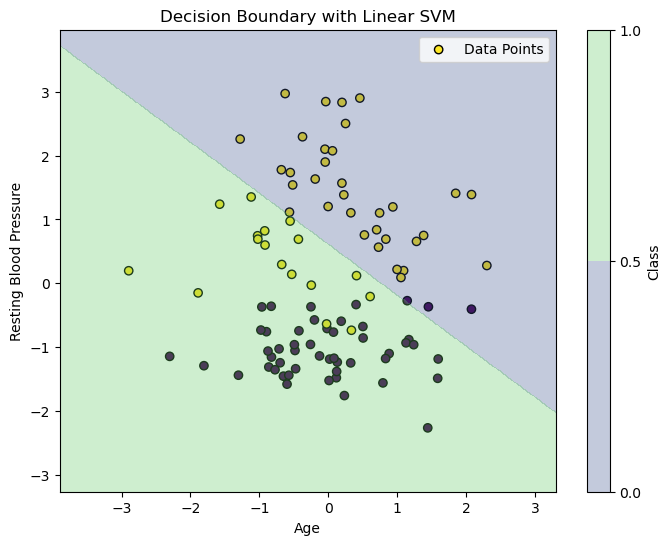

In [56]:
# Select two features for visualization
feature_1 = 'age'
feature_2 = 'trestbps'
label_1 = 'Age'
label_2 = 'Resting Blood Pressure'
# Get x,y column indices
feature1_index = df.columns.get_loc(feature_1)
feature2_index = df.columns.get_loc(feature_2)
selected_features = [feature1_index, feature2_index]  # Replace with the indices of the two features you want to use

# Retain only the selected features from the training data
X_train_selected = X_train_subset[:, selected_features]

# Train a new SVM model using only the selected features
svm_linear_selected = SVC(kernel='linear', C=1E10)
svm_linear_selected.fit(X_train_selected, y_train_subset)

# Generate synthetic 13-dimensional dataset
X, y = make_classification(n_samples=100, n_features=13, n_classes=2, n_clusters_per_class=1, random_state=42)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.scatter(X[:, feature1_index], X[:, feature2_index], c=y, cmap='viridis', marker='o', edgecolors='k', label='Data Points')

# Create a mesh grid to plot decision boundary
xx, yy = np.meshgrid(np.linspace(X[:, feature1_index].min() - 1, X[:, feature1_index].max() + 1, 500),
                     np.linspace(X[:, feature2_index].min() - 1, X[:, feature2_index].max() + 1, 500))
Z = svm_linear_selected.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis', levels=[0, 0.5, 1])
plt.colorbar(label='Class')

plt.xlabel(label_1)
plt.ylabel(label_2)
plt.title('Decision Boundary with Linear SVM')
plt.legend()
plt.show()